**Table of contents**<a id='toc0_'></a>    
- [Libraries](#toc1_1_)    
- [Option 1: Search by Ingredients](#toc2_)    
  - [Tokenization](#toc2_1_)    
  - [Modeling](#toc2_2_)    
    - [Word2vec](#toc2_2_1_)    
    - [Model Evaluation](#toc2_2_2_)    
    - [Word Embeddings](#toc2_2_3_)    
    - [Vectorisation](#toc2_2_4_)    
      - [TFIDF Embedding Vectoriser](#toc2_2_4_1_)    
  - [Recommendations](#toc2_3_)    
    - [Checking results](#toc2_3_1_)    
- [Option 2: Search by Keywords](#toc3_)    
  - [Tokenization](#toc3_1_)    
  - [Modeling](#toc3_2_)    
    - [Vectorization](#toc3_2_1_)    
  - [Recommendation](#toc3_3_)    
    - [Checking results](#toc3_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Importing Dataset & Libraries](#toc0_)


In this section I will explore TFIDF vectorization for modeling and recommendations

In [42]:
#importing the basic libraries
import numpy as np
import pandas as pd

#visualisation libraries
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [43]:
#importing the word processing libraries


 #importing the regex library
import re

#importing the nltk library
import nltk


#lemmatizer
from nltk.stem import WordNetLemmatizer

#  nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

#defining the stop words
ENGLISH_STOP_WORDS = stopwords.words('english')

#library to handle punctuation
import string

#counter library
from collections import Counter

import spacy

#speech tagging library
from nltk import pos_tag

#library for word embedding
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e312995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
#loading the cleaned dataset
recipes = pd.read_csv('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/Datasets/recipes_cleaned.csv')

In [45]:
#checking
recipes.shape

(521766, 32)

In [46]:
#checking the column names
recipes.columns

Index(['Unnamed: 0', 'RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime',
       'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images',
       'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities',
       'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories',
       'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions',
       'length of ingredients', 'length_of_titles', 'Vegan/Not'],
      dtype='object')

As the next step, I will be refining the ingredients data to avoid biases from different words and to have more consistency for comparsion of the input data vs the recipe data in the database

In Sprint 1, I followed a process where I had multiple lines of codes for each data cleaning step, here I am creating one parser function which can be used to clean both ingredients and title columns. Furthermore in Sprint 1, my ingredients were cleaned in a way that an example of 'red cabbage' would produce 2 tokens red and cabbage seperately, but in the project context, these words should remain in the original form as red cabbage to make sense. So I have changed my cleaning steps to incorporate that.

As the recipes will usually contain alot of measuring terms and this will repeat, I will remove them from the list for the cleaning purpose to remove the biases from them.

Next I will
- break each ingredient list to tokens/words
- lower case
- remove stop words
- remove verbs
- remove measuring word
- remove characters and numbers

All this is done to remove any impact from those words/tokens to the tool as the recommendation engine should only map for the true ingredients.

# <a id='toc2_'></a>[Option 1: Search by Ingredients](#toc0_)

## <a id='toc2_1_'></a>[Tokenization](#toc0_)

In [47]:
def parser(input_keys): #function
    
    remove_= { 'oil', 'salt', 'pepper'}

#defining measuring units

    measurment_url= 'https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement' #data source


    measuring_words= ['ml', 'mL', 'milliliter', 'millilitre', 'cc' , 'cubic centimeter', 'l', 'L', 'liter', 'litre', 'dl', 'dL', 'deciliter', 'decilitre', 'teaspoon', 't' , 'tsp.',
'tablespoon' , 'T', 'tbl', 'tbs', 'tbsp', 'fluid ounce', 'fl oz',  'gill', 'cup',  'c', 'pint', 'p', 'pt', 'fl pt',
'quart', 'q', 'qt', 'fl qt', 'gallon' , 'g' , 'gal' , 'g', 'milligram', 'milligramme', 'g' , 'gram' , 'gramme', 'kg',
'kilogram', 'kilogramme', 'pound', 'lb', 'ounce', 'oz', 'mm', 'millimeter', 'millimetre', 'cm' , 'centimeter', 'centimetre', 'm' , 'meter',
'metre', 'inch', 'in', 'yard', '°C' , 'degree celsius','°F' ,'Farenheit', 'tsp']



    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas

    cleaned_ingredients = [] #new list to store cleaned ingredients

    lemmatizer = WordNetLemmatizer() #lemmatizer

    for ingredient in ingredients_list:
        items = re.split(' ', ingredient)  #splitting each ingredient by space to process and clean each individual word

        items = [word for word in items if word.isalpha()] #filtering only letters

        #tagged_items= pos_tag(items) #tagging the words to identify verbs

        #items= [word for word, pos in tagged_items if not pos.startswith('VB')] #filtering to remove any word which is a verb

        items = [word.lower() for word in items] #lowercasing

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        items = [word for word in items if word not in measuring_words] #removing measuring words

        items = [word for word in items if word not in remove_]

        if items:
            cleaned_ingredients.append(' '.join(items) ) #joining the individual words of the ingredient seperated by space


    return cleaned_ingredients #return the list


In [48]:
ingredients= recipes['RecipeIngredientParts']
ingredients_cleaned = ingredients.apply(parser)

Perfect, I have my ingredients seperated by a comma in original form.

## <a id='toc2_2_'></a>[Modeling](#toc0_)

### <a id='toc2_2_1_'></a>[Word2vec](#toc0_)

Since this is a text analysis, I will use Word2vec which will enable creating embeddings for each word which then can be  converted to a vector for further analysis.

In [49]:
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=300, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out

### <a id='toc2_2_2_'></a>[Model Evaluation](#toc0_)

In [50]:
phrases_model.get_latest_training_loss()

3214393.5

In [51]:
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=200, compute_loss=True)
phrases_model.get_latest_training_loss()

3396663.0

In [52]:
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=100, compute_loss=True)
phrases_model.get_latest_training_loss()

3307047.5

ingredients_cleaned = ingredients.apply(parser)

import time

train_time_values = []
seed_val = 42

hs_values = [0, 1]
vector_values= [100,200,300]
window_values= [10,13,15,18]




for data in ingredients_cleaned:
    for vector in vector_values:
        for hs_val in hs_values:
            for window in window_values:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = Word2Vec(
                        data,
                        compute_loss=True,
                        window= window,
                        vector_size=vector,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                    
                    'compute_loss': w2v_model.get_latest_training_loss(),
                    'vector': vector,
                    'window': window,
                    'hs_val': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data',  'hs', 'compute_loss'],
    ascending=[False, False, False],
)
print(train_times_table)

In [53]:
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=200, compute_loss=True, hs=0)
phrases_model.get_latest_training_loss()

3371623.75

### <a id='toc2_2_3_'></a>[Word Embeddings](#toc0_)

In [54]:
#getting the word embeddings to compare different ingredients
embeddings= {word: phrases_model.wv[word] for word in phrases_model.wv.index_to_key} 

Checking similar words to different ingredients 

In [55]:
print(phrases_model.wv.most_similar(u'onion', topn=5)) #checking the most similar results for onion

[('yellow onion', 0.7901095747947693), ('spanish onion', 0.7281932830810547), ('sweet onion', 0.6924917697906494), ('yellow sweet onion', 0.5657068490982056), ('red onion', 0.5507315993309021)]


Let's check some similar ingredients to see if the mdoel has been trained well.

In [56]:
print(phrases_model.wv.most_similar(u'garlic', topn=5)) #again checkin the most similar words to garlic

[('garlic clove', 0.9378972053527832), ('minced garlic clove', 0.8819165229797363), ('fresh garlic', 0.8147859573364258), ('fresh garlic clove', 0.7840474247932434), ('bulb garlic', 0.5750582218170166)]


In [57]:
phrases_model.wv.most_similar(['cheese', 'pasta'], topn=10) #checking for cheese pasta

[('penne', 0.7199059128761292),
 ('dry pasta', 0.7177255153656006),
 ('pasta shell', 0.6932721734046936),
 ('parmigiano', 0.689092755317688),
 ('rigatoni pasta', 0.6874717473983765),
 ('penne pasta', 0.679279088973999),
 ('farfalle pasta', 0.6643875241279602),
 ('pecorino romano cheese', 0.6529645323753357),
 ('shell pasta', 0.6523211598396301),
 ('whole wheat pasta', 0.6441613435745239)]

I will try to use a tile map to show the similarity of a few ingredients

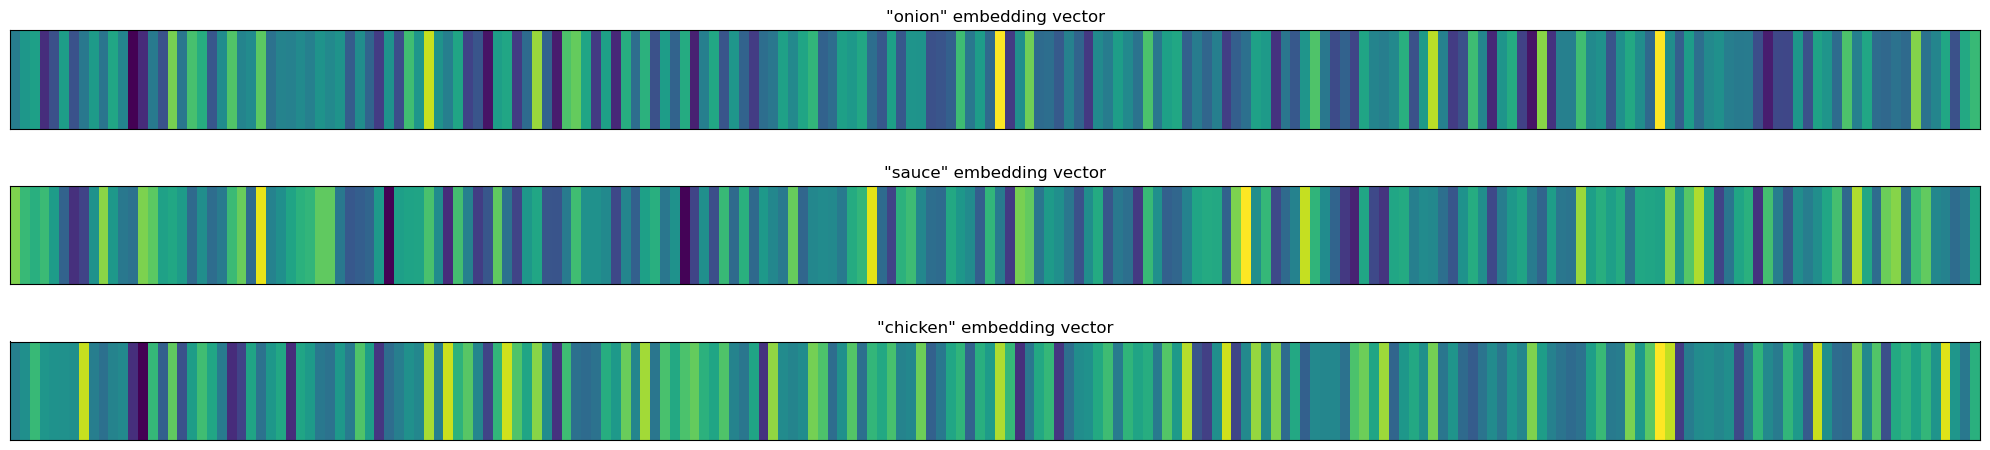

In [58]:
word_list = ['onion', 'sauce', 'chicken'] #example

plt.subplots(len(word_list), 1, figsize=(20, 5)) #plot

for i, word in enumerate(word_list): #for loop to get each word in the list
    plt.subplot(len(word_list), 1, i + 1) #subplot
    plt.imshow(np.tile(embeddings[word], (10, 1))) #data
    plt.xticks([]) #no xticks
    plt.yticks([]) #no yticks
    plt.title(f"\"{word}\" embedding vector") #title

plt.tight_layout()
plt.show()

It is visible that words such as onion, sauce, chicken show similar distribution where as fish  is  different, which is right.Lets see why chicken shows similar behavior

In [59]:
#saving the model
phrases_model.save('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/phrases_model.bin')

### <a id='toc2_2_4_'></a>[Vectorisation](#toc0_)

#### <a id='toc2_2_4_1_'></a>[TFIDF Embedding Vectoriser](#toc0_)

I will  create a TFIDF Mean Vectoriser as it would help to get kore context on the words than just the occurence counts. TFIDF will identify the importance of an ingredient in the context of the total list of ingredients.

In [60]:
#mean word vectors class

class TFIDFMeanEmbeddingVector(object):

    def __init__(self, phrases_model):

        """

        input : phrases model
        output: average embeddings for each ingredient list

        """


        self.phrases_model= phrases_model #model
        self.word_idf_weight= None
        self.vector_size= phrases_model.wv.vector_size #vector size



    def fit(self, docs): #fit


        text_docs= []

        for doc in docs:
            text_docs.append(' '. join(doc))   #append using space

        tfidf= TfidfVectorizer(ngram_range=(1,2))

        tfidf.fit(text_docs) #fitting

        max_idf= max(tfidf.idf_) #max idf definition,  if a word was never seen it is given idf of the max of known idf value

        self.word_idf_weight= defaultdict(
                                            lambda : max_idf, 
                                            [(word, tfidf.idf_[i])  for word, i in tfidf.vocabulary_.items()])


        return self


    def transform(self, docs): #transforming the docs

        doc_word_vector= self.doc_average_list(docs)

        return doc_word_vector


    def doc_average(self, doc): #function to get the average embedding for one ingredient list

        mean= []

        for word in doc: #for each ingredient

            if word in self.phrases_model.wv.index_to_key: #if ingredient is in the vocabulary
                mean.append(self.phrases_model.wv.get_vector(word) * self.word_idf_weight[word]) #get the mean for the word

        if not mean: #if not mean, return zeros to the size of the model vectors
            return np.zeros(self.vector_size)

        else: #if mean <> empty, get the mean across the axis =0
            mean= np.array(mean).mean(axis=0)

            return mean #return mean


    def doc_average_list (self, docs): #function to get the average embeddings for the total list of ingredients

            return np.vstack([self.doc_average(doc) for doc in docs]) #stacking the individual word averages for each ingredient in the list

## <a id='toc2_3_'></a>[Recommendations](#toc0_)

Next step is to get these mean word vectors and create the recommendations. I will create a function to give the recoomendations based on the N defined, input ingredients and the cosine similarity between the input and the ingredients in recipes

In [61]:
def get_recommendations (N, score):

     """

     Top recommendations,

        input :  N, cosine similiarity scores
        output : top N recommendations in a dataframe with title, ingredients, score

     """
    
     top_recipes= sorted(range(len(score)), key=lambda i : score[i], reverse= True) [:N] #sorting the recipes by the score, getting the N results

     recommendation= pd.DataFrame( columns=['title','ingredients', 'score'] ) #dataframe with columns

     count= 0

     for i in top_recipes: #defining the data for each recommendation

        try:
            title = recipes['Name'].iloc[i]
            calories = recipes['Calories'].iloc[i]
            time= recipes['TotalTime'].iloc[i]
            ingredients = recipes['RecipeIngredientParts'].iloc[i]
            recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
        
        except IndexError as e:
            # Handle missing index
            print(f"Error: Index {i} not found in recipes DataFrame. Skipping this entry.")



        count += 1 #for count + 1 th row


     return recommendation #recommendation dataframe






def recommendation_working (input_ingredients, N=20, mean= False):

    """

    fucntion to calculate the recommendations

        input : input ingredients seperated by commas, tuple
        N: 5
        output: recommendations dataframe

    """

    

    model= Word2Vec.load('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/phrases_model.bin') #loading the saved model


    model.wv.init_sims() #normalizing the embeddings

    recipes = pd.read_csv('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/Datasets/recipes_cleaned.csv')

    data= recipes #getting the recipe data

    data['ingredients_cleaned']= data['RecipeIngredientParts'].apply(parser)

    
    tfidf_vector= TFIDFMeanEmbeddingVector(model) #tfidf for all words

    tfidf_vector.fit(ingredients_cleaned) #fit

    doc_vec= tfidf_vector.transform(ingredients_cleaned) #transform


    doc_vec = [doc.reshape(1, -1) for doc in doc_vec] #reshape

    recipes= pd.read_csv('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/Datasets/recipe_sample_3.csv')

    recipes['ingredients_cleaned']= recipes['RecipeIngredientParts'].apply(parser)

    


    

    #user input mapping

    #input= input_ingredients #input ingredients

    
    formatted_input = ','.join(map(str, input_ingredients)) #converting to str, mapping and joining by the ','
    
    formatted_input.split(',')

    input= parser(formatted_input) #apply the parser to clean

    recommendations= None

    for sublist in recipes['ingredients_cleaned']:
        if any(word in sublist for word in input):
            input_embedding= tfidf_vector.transform([input])[0].reshape(1,-1) #getting the TFIDF average embdeddings for the input giving the shape of 1,
            cosine_sim= map(lambda x: cosine_similarity(input_embedding, x)[0][0], doc_vec) #cosine sim. between the input and the doc of vector
            score= list(cosine_sim) #listing scores
            recommendations = get_recommendations(N, score) #
            break
        
    return recommendations #return recommendations

    
    




### <a id='toc2_3_1_'></a>[Checking results](#toc0_)

We will test the model and see the results.

In [62]:
input_ingredients= 'cheese', 'pasta'
recommendation_working(input_ingredients)



C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:60: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings


C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 

,title,ingredients,score,calories,time
0,Vegeroni,"pasta, cheese",1.0000000000000004,390.9,PT25M
1,Sweet Lunchbox Noodles,"pasta, cheese",1.0000000000000004,324.7,PT5M
2,Smart Alec Pork Neck Bones Spaghetti - Pressur...,"pasta, cheese, water",0.9477528034406575,355.8,PT1H30M
3,Awesome Pasta Sauce,pasta,0.9152192326932014,771.1,PT10H5M
4,Pasta with Creamy Red Roasted Pepper Sauce,pasta,0.9152192326932014,332.5,PT25M
5,"Really Really Really, Too Easy Kids Pasta",pasta,0.9152192326932014,309.2,PT15M
6,Chicken &amp; Veggie Pasta,pasta,0.9152192326932014,585.6,PT30M
7,Colored Pasta Macaroni for Crafts,pasta,0.9152192326932014,845.9,PT5M
8,Student Meal- Pasta and Beans :),pasta,0.9152192326932014,325.2,PT10M
9,Low-Carb Pizza,"pasta, cheese, onion",0.9146010494298713,193.4,PT13M


In [63]:
input_ingredients= 'hamburger', 'cheese'

recommendation_working(input_ingredients)

C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:60: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]

,title,ingredients,score,calories,time
0,Easy Mexican Bean Dip,"hamburger, cheese",1.0000000000000002,342.1,PT20M
1,Taco Tot Hotdish,"hamburger, cheese",1.0000000000000002,1000.8,PT45M
2,Tator Tot Casserole,"hamburger, cheese",1.0000000000000002,887.3,PT30M
3,Ramen Noodle Vegetable Soup,hamburger,0.9586902786605065,444.0,PT40M
4,Hamburger Refried Bean Dip,hamburger,0.9586902786605065,506.2,PT20M
5,Easy Chili,hamburger,0.9586902786605065,216.5,PT25M
6,Tomato Goulash,hamburger,0.9586902786605065,770.0,PT30M
7,Frozen Baby Meal 1 of 6 (Spaghetti),hamburger,0.9586902786605065,17.4,PT30M
8,Becky's Tater Tot Casserole,hamburger,0.9586902786605065,922.1,PT15M
9,Last Minute Helper (Like Hamburger Helper),"hamburger, salt, pepper",0.9586902786605065,542.3,PT20M


In [64]:
input_ingredients=  'tofu', 'onion', 'bell pepper'

recommendation_working(input_ingredients)

C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:60: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\972091177.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]

,title,ingredients,score,calories,time
0,"Quick, Colourful Tofu Stir-Fry","pak choi, bell pepper, onion, garlic clove, to...",0.8752660216138339,179.4,PT15M
1,Peach-Glazed Tofu,"tofu, onions",0.832829087903161,164.3,PT2H
2,Vegan Stuffed Bell Peppers,"bell peppers, tofu, garlic cloves, fresh spina...",0.8271929208894653,231.7,PT35M
3,Healthy Stuffed Bell Peppers,"bell peppers, onion, mushroom, cooked brown ri...",0.8254824300573911,247.5,PT1H10M
4,Beans and Rice,"rice, water, vegetarian refried beans, extra f...",0.8096504747796298,420.9,PT37M
5,Chilli Chicken Cauldrons (Halloween),"onion, chicken fillets, bell peppers",0.8095694279095533,130.9,PT1H45M
6,Thai Lentil Quinoa Bowl,"quinoa, water, lentils, water, bell pepper, on...",0.8020581485583856,482.9,PT30M
7,Vegan Shepherd's Omelet,"extra firm tofu, soymilk, salt, green onion, o...",0.8000655263643525,648.6,PT1H15M
8,Texas Tooth Picks,"onion, bell pepper",0.7953576696177007,28.1,PT24M
9,Newlywed Hamburger Casserole With French Fried...,"onion, bell pepper",0.7953576696177007,487.7,PT45M


# <a id='toc3_'></a>[Option 2: Search by Keywords](#toc0_)

In [65]:
#combining text columns

recipes['text_data']= recipes[['Name', 'RecipeCategory', 'Keywords']].astype(str).agg(','.join, axis=1) 

In [66]:
#sanity check
recipes.head()

,Unnamed: 0,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,...,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,length of ingredients,length_of_titles,Vegan/Not,text_data
0,0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,...,3.6,30.2,3.2,4.0,NaN,"Toss 2 cups berries with sugar., Let stand for...",7,5,Non-Vegan,"Low-Fat Berry Blue Frozen Dessert,Frozen Desse..."
1,1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,...,9.0,20.4,63.4,6.0,NaN,Soak saffron in warm milk for 5 minutes and pu...,38,1,Non-Vegan,"Biryani,Chicken Breast,Chicken Thigh & Leg, Ch..."
2,2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,...,0.4,77.2,0.3,4.0,NaN,"Into a 1 quart Jar with tight fitting lid, put...",12,2,Non-Vegan,"Best Lemonade,Beverages,Low Protein, Low Chole..."
3,3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,...,17.3,32.1,29.3,2.0,4 kebabs,"Drain the tofu, carefully squeezing out excess...",28,3,Non-Vegan,"Carina's Tofu-Vegetable Kebabs,Soy/Tofu,Beans,..."
4,4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,...,4.8,17.7,4.3,4.0,NaN,"Mix everything together and bring to a boil., ...",7,2,Vegan,"Cabbage Soup,Vegetable,Low Protein, Vegan, Low..."


In [67]:
recipes['text_data']
text_data= recipes['text_data']

## <a id='toc3_1_'></a>[Tokenization](#toc0_)

In [68]:
remove_= { 'oil', 'salt', 'pepper'}

def parser_text(input_keys): #function

    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas
    ingredients_list = re.split(' ', input_keys) #splitting the ingredients by commas

    cleaned_ingredients = [] #new list to store cleaned ingredients

    lemmatizer = WordNetLemmatizer() #lemmatizer

    for ingredient in ingredients_list:
        items = re.split(',', ingredient)  #splitting each ingredient by space to process and clean each individual word

        items = [word for word in items if word.isalpha()] #filtering only letters


        items = [word.lower() for word in items] #lowercasing

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        #items = [word for word in items if word not in measuring_words] #removing measuring words

        items = [word for word in items if word not in remove_]

        if items:
            cleaned_ingredients.append(','.join(items) ) #joining the individual words of the ingredient seperated by space
    

    return cleaned_ingredients #return the list


In [69]:
#applying the parser
text_data_cleaned = text_data.apply(parser)

## <a id='toc3_2_'></a>[Modeling](#toc0_)

In [70]:
phrases_model_2=Word2Vec(sentences=text_data_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=100, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out
#saving the model
phrases_model_2.save('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/phrases_model_2.bin')


In [71]:
training_loss= phrases_model_2.get_latest_training_loss()
print(training_loss)

2640253.0


### <a id='toc3_2_1_'></a>[Vectorization](#toc0_)

In [72]:
#mean word vectors class

class TFIDFMeanEmbeddingVector(object):

    def __init__(self, phrases_model):

        """

        input : phrases model
        output: average embeddings for each ingredient list

        """


        self.phrases_model= phrases_model #model
        self.word_idf_weight= None
        self.vector_size= phrases_model.wv.vector_size #vector size



    def fit(self, docs): #fit


        text_docs= []

        for doc in docs:
            text_docs.append(' '. join(doc))   #append using space

        tfidf= TfidfVectorizer(ngram_range=(1,2))

        tfidf.fit(text_docs) #fitting

        max_idf= max(tfidf.idf_) #max idf definition,  if a word was never seen it is given idf of the max of known idf value

        self.word_idf_weight= defaultdict(
                                            lambda : max_idf, 
                                            [(word, tfidf.idf_[i])  for word, i in tfidf.vocabulary_.items()])



        


        return self


    def transform(self, docs): #transforming the docs

        doc_word_vector= self.doc_average_list(docs)

        return doc_word_vector


    def doc_average(self, doc): #function to get the average embedding for one ingredient list

        mean= []

        for word in doc: #for each ingredient

            if word in self.phrases_model.wv.index_to_key: #if ingredient is in the vocabulary
                mean.append(self.phrases_model.wv.get_vector(word) * self.word_idf_weight[word]) #get the mean for the word

        if not mean: #if not mean, return zeros to the size of the model vectors
            return np.zeros(self.vector_size)

        else: #if mean <> empty, get the mean across the axis =0
            mean= np.array(mean).mean(axis=0)

            return mean #return mean


    def doc_average_list (self, docs): #function to get the average embeddings for the total list of ingredients

            return np.vstack([self.doc_average(doc) for doc in docs]) #stacking the individual word averages for each ingredient in the list

## <a id='toc3_3_'></a>[Recommendation](#toc0_)

In [73]:
def get_recommendations_2 (N, score):

     """

     Top recommendations,

        input :  N, cosine similiarity scores
        output : top N recommendations in a dataframe with title, ingredients, score

     """

     top_recipes= sorted(range(len(score)), key=lambda i : score[i], reverse= True) [:N] #sorting the recipes by the score, getting the N results

     recommendation= pd.DataFrame( columns=['title','ingredients', 'score'] ) #dataframe with columns

     count= 0

     for i in top_recipes: #defining the data for each recommendation
        try:

            title = recipes['Name'].iloc[i]
            calories= recipes['Calories'].iloc[i]
            time= recipes['TotalTime'].iloc[i]
            ingredients = recipes['RecipeIngredientParts'].iloc[i]
            category = recipes['RecipeCategory'].iloc[i]
            keywords = recipes['Keywords'].iloc[i]
            recommendation = recommendation.append({'title': title, 'category': category, 'keywords': keywords, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
        
        except IndexError as e:
            # Handle missing index
            print(f"Error: Index {i} not found in recipes DataFrame. Skipping this entry.")

        
        
        count += 1 #for count + 1 th row


     return recommendation #recommendation dataframe



def recommendation_working_2 (input_text, N=20, mean= False):

    """

    fucntion to calculate the recommendations

        input : input ingredients seperated by commas, tuple
        N: 5
        output: recommendations dataframe

    """

    model= Word2Vec.load('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/Documents/PERSONAL/BRAINSTATION/CAPSTONE/phrases_model_2.bin') #loading the saved model

    model.wv.init_sims() #normalizing the embeddings

    data= recipes #getting the recipe data

    data['text_data_cleaned']= data['text_data'].apply(parser_text)
    
    tfidf_vector= TFIDFMeanEmbeddingVector(model) #tfidf for all words

    tfidf_vector.fit(text_data_cleaned) #fit

    doc_vec= tfidf_vector.transform(text_data_cleaned) #transform

        

    doc_vec = [doc.reshape(1, -1) for doc in doc_vec] #reshape


    #user input mapping

    input= input_text #input ingredients

    input.split(',')

    

    input= parser_text(input) #apply the parser to clean



    for sublist in data['text_data_cleaned']:
        if all(word in sublist for word in input):
            input_embedding= tfidf_vector.transform([input])[0].reshape(1,-1) #getting the TFIDF average embdeddings for the input giving the shape of 1,
            cosine_sim= map(lambda x: cosine_similarity(input_embedding, x)[0][0], doc_vec) #cosine sim. between the input and the doc of vector
            score= list(cosine_sim) #listing scores
            recommendations = get_recommendations_2(N, score) #calculating the recommendation score
            
    return recommendations #return recommendations

    


### <a id='toc3_3_1_'></a>[Checking results](#toc0_)

In [74]:
input_text= 'japanese soup'

recommendation_working_2(input_text)

C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\1885414955.py:56: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\1885414955.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'category': category, 'keywords': keywords, 'ingredients': ingredients, 'calories' : calories, 'time' : time, 'score': f"{score[i]}"}, ignore_index=True)
C:\Users\e312995\AppData\Local\Temp\ipykernel_28048\1885414955.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recommendation = recommendation.append({'title': title, 'category': category, 'keywords': keywo

,title,ingredients,score,category,keywords,calories,time
0,Ramen Delight,"frozen spinach, egg",0.918712317943573,Lunch/Snacks,"Chinese, Japanese, Korean, Asian, < 15 Mins, B...",453.6,PT7M
1,Teriyaki Marinade,"soy sauce, rice vinegar, garlic clove, brown s...",0.9048633575439453,Chinese,"Japanese, Asian, Low Cholesterol, < 15 Mins, Easy",405.9,PT5M
2,Asian Style Cold-Udon Noodles,"udon noodles, lettuce, cabbage, cucumber, red ...",0.902176022529602,Japanese,"Korean, Asian, < 4 Hours",2982.4,PT1H5M
3,Stir Fry Veggies Yumm Yumm,"extra virgin olive oil, garlic, broccoli flore...",0.9014802575111389,Vegetable,"Chinese, Japanese, Asian, < 30 Mins, Easy",176.4,PT20M
4,"Beef, Cod Fish and Soy Milk Stew","potato, zucchini, garlic clove, bean sprouts, ...",0.8994371891021729,Meat,"Japanese, Korean, Asian, < 30 Mins",229.1,PT28M
5,P. F. Changs Sauce for Fried Green Beans Appet...,"hot chili sauce, green onions, garlic cloves",0.8952789306640625,Chinese,"Japanese, Asian, < 15 Mins, Beginner Cook, Easy",8.6,PT5M
6,Beef and Dumpling Soup,"garlic cloves, fresh ginger, kaffir lime leave...",0.8944909572601318,Japanese,"Thai, Asian, < 15 Mins",87.7,PT15M
7,Pot Stickers (War Teep) / Gyoza Dim Sum / Deem...,"all-purpose flour, salt, warm water, ground po...",0.8942036628723145,Chinese,"Japanese, Asian, < 4 Hours",73.1,PT2H40M
8,Delicious Singapore Style Noodles,"unsalted peanuts, cashew nuts, ground pork, ol...",0.8941717147827148,Japanese,"Thai, Asian, < 60 Mins",375.7,PT35M
9,Yakisoba (Japanese Style Chow Mein),"angel hair pasta, pork, carrot, cabbage, shiit...",0.8887242078781128,Meat,"Hunan, Chinese, Japanese, Asian, < 30 Mins",149.4,PT20M
